# Visão Geral do Projeto

Neste projeto, eu vou realizar uma **análise de sentimentos em viagens aéreas**, usando como base avaliações e reviews deixados por passageiros em voos de diferentes companhias aéreas.

Ao longo do documento, eu vou aplicar técnicas de **Processamento de Linguagem Natural (NLP)** para entender quais aspectos impactam positivamente ou negativamente a experiência do cliente.

Especificamente, eu vou:  
-  Fazer um pré-processamento dos dados, corrigindo erros e organizando as informações.  
- Explorar os dados para identificar padrões, como a relação entre as notas dadas e o tipo de aeronave ou companhia.  
- Aplicar técnicas de NLP nos textos das reviews para extrair insights sobre as principais palavras e sentimentos expressos.  
- Construir modelos de **classificação de sentimentos** para prever se um passageiro ficou satisfeito (positivo), neutro ou insatisfeito (negativo), usando tanto os textos quanto as notas individuais das categorias (como conforto do assento, atendimento, alimentação etc.).  
- Avaliar o impacto de atrasos de viagem no NPS (Net Promoter Score) das principais companhias, identificando quanto isso pesa na percepção geral do passageiro.


# Importância do Projeto

A ideia é ajudar as companhias aéreas a entender que a percepção dos passageiros vai muito além da nota final.  
Ao fazer essa análise, eu consigo identificar quais pontos específicos da experiência precisam de atenção, seja no atendimento, alimentação, conforto, entretenimento a bordo ou conectividade.

Além disso, ao construir modelos preditivos, eu consigo antecipar tendências de satisfação (ou insatisfação) e gerar insights que permitem às empresas agirem de forma proativa para melhorar seus serviços.  
Com a análise de texto, eu também vou capturar nuances que muitas vezes passam despercebidas em análises puramente numéricas.

O resultado final permitirá que as empresas:  
- Priorizem investimentos em melhorias.  
- Reduzam churn e aumentem a fidelização.  
- Melhorem o NPS, que é um indicador-chave para crescimento no setor de aviação.

# Dicionário de Dados

É importante entender o que cada coluna do dataset representa, então por mais que eu vou importar ele a seguir, já deixarei aqui a explicação do que é cada variável:

- Airline Name: Nome da companhia aérea.
- Overall_Rating: Nota geral dada pelo passageiro.
- Review_Title: Título da avaliação escrita pelo passageiro.
- Review Date: Data em que a avaliação foi feita.
- Review: Texto completo da avaliação escrita pelo passageiro.
- Aircraft: Modelo de aeronave utilizado no voo.
- Type Of Traveller: Tipo de passageiro (por exemplo, Business, Family, Couple).
- Seat Type: Tipo de assento (Economy Class, Business Class, etc.).
- Route: Origem e destino do voo.
- Date Flown: Data em que o voo foi realizado.
- Seat Comfort: Nota para conforto do assento.
- Cabin Staff Service: Nota para atendimento da tripulação.
- Food & Beverages: Nota para comida e bebidas.
- Ground Service: Nota para atendimento em solo.
- Inflight Entertainment: Nota para entretenimento a bordo.
- Wifi & Connectivity: Nota para conectividade e Wi-Fi durante o voo.


# Imports das bibliotecas

In [1]:
# Imports das bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import string
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

import re
import math

# Configuração para exibir gráficos no notebook
%matplotlib inline

# Ignorar warnings
warnings.filterwarnings('ignore')

# Análise Exploratória

In [2]:
# Carregar o dataset
url = 'https://raw.githubusercontent.com/Henrique-Peter/analise_sentimentos_comp_aerea/refs/heads/main/Travel_Chalenge.csv'
df = pd.read_csv(url, sep=';', encoding='utf-8')

# Exibir as primeiras linhas
df.head()

,Airline Name,Overall_Rating,Review_Title,Review Date,Review,Aircraft,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Inflight Entertainment,Wifi & Connectivity
0,Air Seychelles,8,Air Seychelles customer review,10th April 2011,LHR-SEZ-LHR. It's true that there aren't perso...,NaN,NaN,Economy Class,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CityJet,1,CityJet customer review,10th April 2011,London City to Antwerp was delayed 3 hours 40 ...,NaN,NaN,Economy Class,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Shanghai Airlines,9,Shanghai Airlines customer review,10th April 2012,PEK to HGH in Economy. Slight delay out of PEK...,NaN,NaN,Economy Class,NaN,NaN,3.0,4.0,4.0,NaN,2.0,NaN
3,Aerolineas Argentinas,8,Aerolineas Argentinas customer review,10th April 2014,Rio to Buenos Aires AEP on 737. Departure dela...,NaN,NaN,Economy Class,NaN,NaN,3.0,4.0,0.0,NaN,0.0,NaN
4,Adria Airways,7,Adria Airways customer review,10th April 2015,Outbound flight FRA/PRN A319. 2 hours 10 min f...,NaN,NaN,Economy Class,NaN,NaN,4.0,4.0,4.0,NaN,0.0,NaN


In [3]:
# Verificar informações gerais
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17702 entries, 0 to 17701
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Airline Name            17702 non-null  object 
 1   Overall_Rating          17702 non-null  object 
 2   Review_Title            17702 non-null  object 
 3   Review Date             17702 non-null  object 
 4   Review                  17702 non-null  object 
 5   Aircraft                5665 non-null   object 
 6   Type Of Traveller       15953 non-null  object 
 7   Seat Type               17461 non-null  object 
 8   Route                   15876 non-null  object 
 9   Date Flown              15944 non-null  object 
 10  Seat Comfort            15456 non-null  float64
 11  Cabin Staff Service     15366 non-null  float64
 12  Food & Beverages        11924 non-null  float64
 13  Ground Service          15056 non-null  float64
 14  Inflight Entertainment  9231 non-null 

Aqui já percebo algumas coisas como:
- `Overall_Rating` é do tipo object, quando deveria ser float.
- `Review Date` e `Date Flown` são object, quando deveriam ser datas.

In [4]:
# Visualizar exemplos únicos de formatos em 'Review Date'
unique_review_dates = df['Review Date'].unique()[:10]

# Visualizar exemplos únicos de formatos em 'Date Flown'
unique_date_flown = df['Date Flown'].unique()[:10]

# Visualizar exemplos únicos de formatos em 'Date Flown'
unique_overall_rating = df['Overall_Rating'].unique()[:10]

unique_review_dates, unique_date_flown, unique_overall_rating

(array(['10th April 2011', '10th April 2012', '10th April 2014',
        '10th April 2015', '10th April 2016', '10th April 2017',
        '10th April 2018', '10th April 2019', '10th April 2020',
        '10th April 2021'], dtype=object),
 array([nan, 'April 2016', 'December 2015', 'April 2017', 'March 2017',
        'March 2018', 'December 2018', 'April 2019', 'April 2020',
        'November 2019'], dtype=object),
 array(['8', '1', '9', '7', '2', '3', '6', '5', '4', 'n'], dtype=object))

Visualizando alguns exemplos das colunas de data, analiso que:
- Review Date → formato como 10th April 2011. Isso significa que vou precisar usar um parser que entenda esses sufixos (“th”, “st”, “nd”) no dia.

- Date Flown → formato como April 2016 (apenas mês e ano, sem dia). Esse formato não inclui dia, então quando eu converter para datetime, o Pandas vai, por padrão, assumir o dia 1. Ou seja, April 2016 → 2016-04-01. Vou manter essa colunas como object no momento, e na parte de feature engineering irei criar outras colunas derivadas dela, evitando o problema de ter todas as datas com o mesmo dia de cada mês.

- Overall_Rating → os valores aparentemente vão até 10, mas existe um erro no meio, que é o valor "n", que deverá ficar como nulo após a conversão.

In [5]:
# Função para remover sufixos do dia
def clean_date_suffix(date_str):
    if pd.isnull(date_str):
        return date_str
    return re.sub(r'(\d{1,2})(st|nd|rd|th)', r'\1', date_str)

# Aplicar na coluna
df['Review Date'] = df['Review Date'].apply(clean_date_suffix)

# Converter para datetime e zerar as horas
df['Review Date'] = pd.to_datetime(df['Review Date'], errors='coerce')
df['Review Date'] = df['Review Date'].dt.normalize()

# Checar quantos valores ficaram nulos
print("Valores nulos após limpeza e conversão:", df['Review Date'].isnull().sum())

# Confirmar tipo final
print("Tipo final da coluna Review Date:", df['Review Date'].dtype)

Valores nulos após limpeza e conversão: 0
Tipo final da coluna Review Date: datetime64[ns]


In [6]:
# Converter Overall_Rating para float
df['Overall_Rating'] = pd.to_numeric(df['Overall_Rating'], errors='coerce')

# Checar quantos valores se tornaram NaN após a conversão
print("Valores nulos após conversão de Overall_Rating:", df['Overall_Rating'].isnull().sum())

# Confirmar tipo final
print("Tipo final da coluna Overall_Rating:", df['Overall_Rating'].dtype)

Valores nulos após conversão de Overall_Rating: 332
Tipo final da coluna Overall_Rating: float64


In [7]:
# Checar valores nulos
df.isnull().sum()

,0
Airline Name,0
Overall_Rating,332
Review_Title,0
Review Date,0
Review,0
Aircraft,12037
Type Of Traveller,1749
Seat Type,241
Route,1826
Date Flown,1758


In [8]:
# Checar registros duplicados
duplicates = df.duplicated().sum()
print(f'{duplicates} linhas duplicadas')

29 linhas duplicadas


As linhas duplicadas serão retiradas posteriormente, visto que não adicionam nenhum valor significativo para a análise e muito menos para os modelos.

In [9]:
# Resumo estatístico para colunas numéricas
df.describe()

,Overall_Rating,Review Date,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Inflight Entertainment,Wifi & Connectivity
count,17370.000000,17702,15456.000000,15366.000000,11924.000000,15056.000000,9231.000000,5243.000000
mean,3.002015,2020-04-09 16:43:44.245848064,2.598344,2.850709,2.536313,2.330433,2.244611,1.800877
min,1.000000,2002-08-25 00:00:00,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,1.000000,2018-09-08 00:00:00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,1.000000,2021-08-14 12:00:00,3.000000,3.000000,2.000000,1.000000,2.000000,1.000000
75%,5.000000,2023-02-06 18:00:00,4.000000,4.000000,4.000000,4.000000,3.000000,2.000000
max,9.000000,2023-07-27 00:00:00,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
std,2.819078,NaN,1.456198,1.595379,1.513762,1.591097,1.486511,1.327095


In [10]:
# Resumo de colunas categóricas
df.describe(include=['object'])

,Airline Name,Review_Title,Review,Aircraft,Type Of Traveller,Seat Type,Route,Date Flown
count,17702,17702,17702,5665,15953,17461,15876,15944
unique,182,14268,17670,835,4,4,11294,108
top,CityJet,Onur Air customer review,LUX-CDG return (and onwards to YUL on AF) 14/1...,A320,Solo Leisure,Economy Class,Melbourne to Sydney,June 2023
freq,100,84,2,768,5780,14987,38,998


# Limpeza e tratamento dos dados

## Tratamento de Duplicatas

Antes de tratar os dados nulos, eu vou remover registros duplicados no dataset.

Manter duplicatas pode gerar viés nas análises e nos modelos, porque representaria dar peso dobrado a alguns passageiros ou voos.  

Por isso, vou identificar e remover duplicatas completas, ou seja, linhas que sejam idênticas em todas as colunas.


In [11]:
# Verificar quantidade de duplicatas
dup_count = df.duplicated().sum()
print(f"Número de registros duplicados antes da remoção: {dup_count}")

# Remover duplicatas
df = df.drop_duplicates()

# Verificar novamente
dup_count_after = df.duplicated().sum()
print(f"Número de registros duplicados após a remoção: {dup_count_after}")

# Verificar novo tamanho do dataframe
print(f"Tamanho atual do dataframe: {df.shape}")

Número de registros duplicados antes da remoção: 29
Número de registros duplicados após a remoção: 0
Tamanho atual do dataframe: (17673, 16)


## Diagnóstico e Tratamento de Dados Nulos

Agora eu vou fazer uma análise completa dos valores nulos no dataset.  

É importante entender não apenas quantos valores faltam, mas também em qual proporção, porque colunas com muitas ausências podem precisar ser removidas.  

Vou gerar um relatório que mostra o número e a porcentagem de valores nulos por coluna.

In [12]:
# Contagem de valores nulos por coluna
missing_counts = df.isnull().sum()

# Proporção de valores nulos por coluna
missing_percent = (missing_counts / len(df)) * 100

# Juntar em um dataframe
missing_df = pd.DataFrame({
    'Missing Count': missing_counts,
    'Missing Percent': missing_percent
}).sort_values(by='Missing Percent', ascending=False)

print("Resumo de dados faltantes por coluna:")
missing_df

Resumo de dados faltantes por coluna:


,Missing Count,Missing Percent
Wifi & Connectivity,12430,70.333277
Aircraft,12008,67.945454
Inflight Entertainment,8442,47.767781
Food & Beverages,5749,32.529848
Ground Service,2617,14.807899
Cabin Staff Service,2307,13.053811
Seat Comfort,2217,12.544559
Route,1797,10.168053
Date Flown,1729,9.783285
Type Of Traveller,1720,9.732360


Não temos tantas colunas assim, então eliminar pode não ser o melhor.

A estratégia mais cuidadosa seria:
- Manter as colunas, mas sinalizar nos modelos e análises que têm muitos nulos.
- Preencher colunas numéricas (Wifi & Connectivity, Inflight Entertainment, etc.) com a média ou mediana.
- Preencher colunas categóricas (Aircraft, Type Of Traveller) com “Unknown”.

Assim, não perdemos nenhuma variável potencialmente informativa. Mesmo colunas com muito nulo podem conter insights valiosos nas linhas que têm informação.

### Imputação de colunas numéricas

Vou usar a mediana para preencher, porque ela é mais robusta a outliers do que a média.

In [13]:
# Pegar colunas numéricas
num_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Filtrar apenas as colunas numéricas que têm nulos
num_cols_with_na = [col for col in num_cols if df[col].isnull().any()]

print("Colunas numéricas com valores nulos:", num_cols_with_na)

# Preencher nulos com mediana
for col in num_cols_with_na:
    median_value = df[col].median()
    df[col].fillna(median_value, inplace=True)
    print(f"Preenchido nulos na coluna '{col}' com mediana: {median_value}")

Colunas numéricas com valores nulos: ['Overall_Rating', 'Seat Comfort', 'Cabin Staff Service', 'Food & Beverages', 'Ground Service', 'Inflight Entertainment', 'Wifi & Connectivity']
Preenchido nulos na coluna 'Overall_Rating' com mediana: 1.0
Preenchido nulos na coluna 'Seat Comfort' com mediana: 3.0
Preenchido nulos na coluna 'Cabin Staff Service' com mediana: 3.0
Preenchido nulos na coluna 'Food & Beverages' com mediana: 2.0
Preenchido nulos na coluna 'Ground Service' com mediana: 1.0
Preenchido nulos na coluna 'Inflight Entertainment' com mediana: 2.0
Preenchido nulos na coluna 'Wifi & Connectivity' com mediana: 1.0


### Imputação de colunas categóricas

Aqui vou preencher com “Unknown” para indicar que não temos informação.

In [14]:
# Pegar colunas categóricas
cat_cols = df.select_dtypes(include=['object']).columns

# Filtrar apenas as colunas categóricas que têm nulos
cat_cols_with_na = [col for col in cat_cols if df[col].isnull().any()]

print("Colunas categóricas com valores nulos:", cat_cols_with_na)

# Preencher nulos com 'Unknown'
for col in cat_cols_with_na:
    df[col].fillna('Unknown', inplace=True)
    print(f"Preenchido nulos na coluna '{col}' com 'Unknown'")

Colunas categóricas com valores nulos: ['Aircraft', 'Type Of Traveller', 'Seat Type', 'Route', 'Date Flown']
Preenchido nulos na coluna 'Aircraft' com 'Unknown'
Preenchido nulos na coluna 'Type Of Traveller' com 'Unknown'
Preenchido nulos na coluna 'Seat Type' com 'Unknown'
Preenchido nulos na coluna 'Route' com 'Unknown'
Preenchido nulos na coluna 'Date Flown' com 'Unknown'


In [15]:
# Verificar se ainda existem valores nulos no dataframe após o tratamento
remaining_nuls = df.isnull().sum()
remaining_nuls = remaining_nuls[remaining_nuls > 0]

if remaining_nuls.empty:
    print("Nenhum valor nulo restante no dataframe após o tratamento.")
else:
    print("Ainda existem valores nulos nas seguintes colunas:")
    print(remaining_nuls)

Nenhum valor nulo restante no dataframe após o tratamento.


Ainda dentro desse tópico, vou fazer as transformações que citei anteriormente na coluna `Date Flown`, separando ela em duas colunas, sendo uma com o mês e a outra com o ano do registro.

In [16]:
# Extrair ano e mês de 'Date Flown' (lembrando que Pandas colocou dia 1 por padrão)
df['Date Flown Parsed'] = pd.to_datetime(df['Date Flown'], format='%B %Y', errors='coerce')
df['Flown Year'] = df['Date Flown Parsed'].dt.year
df['Flown Month'] = df['Date Flown Parsed'].dt.month_name()

# Análise Univariada: Colunas Numéricas

Agora eu vou explorar as distribuições das variáveis numéricas do dataset.  

O objetivo aqui é entender como as notas estão distribuídas (ex: concentração de avaliações altas, baixas, dispersão etc.), o que ajuda a identificar padrões e possíveis outliers.


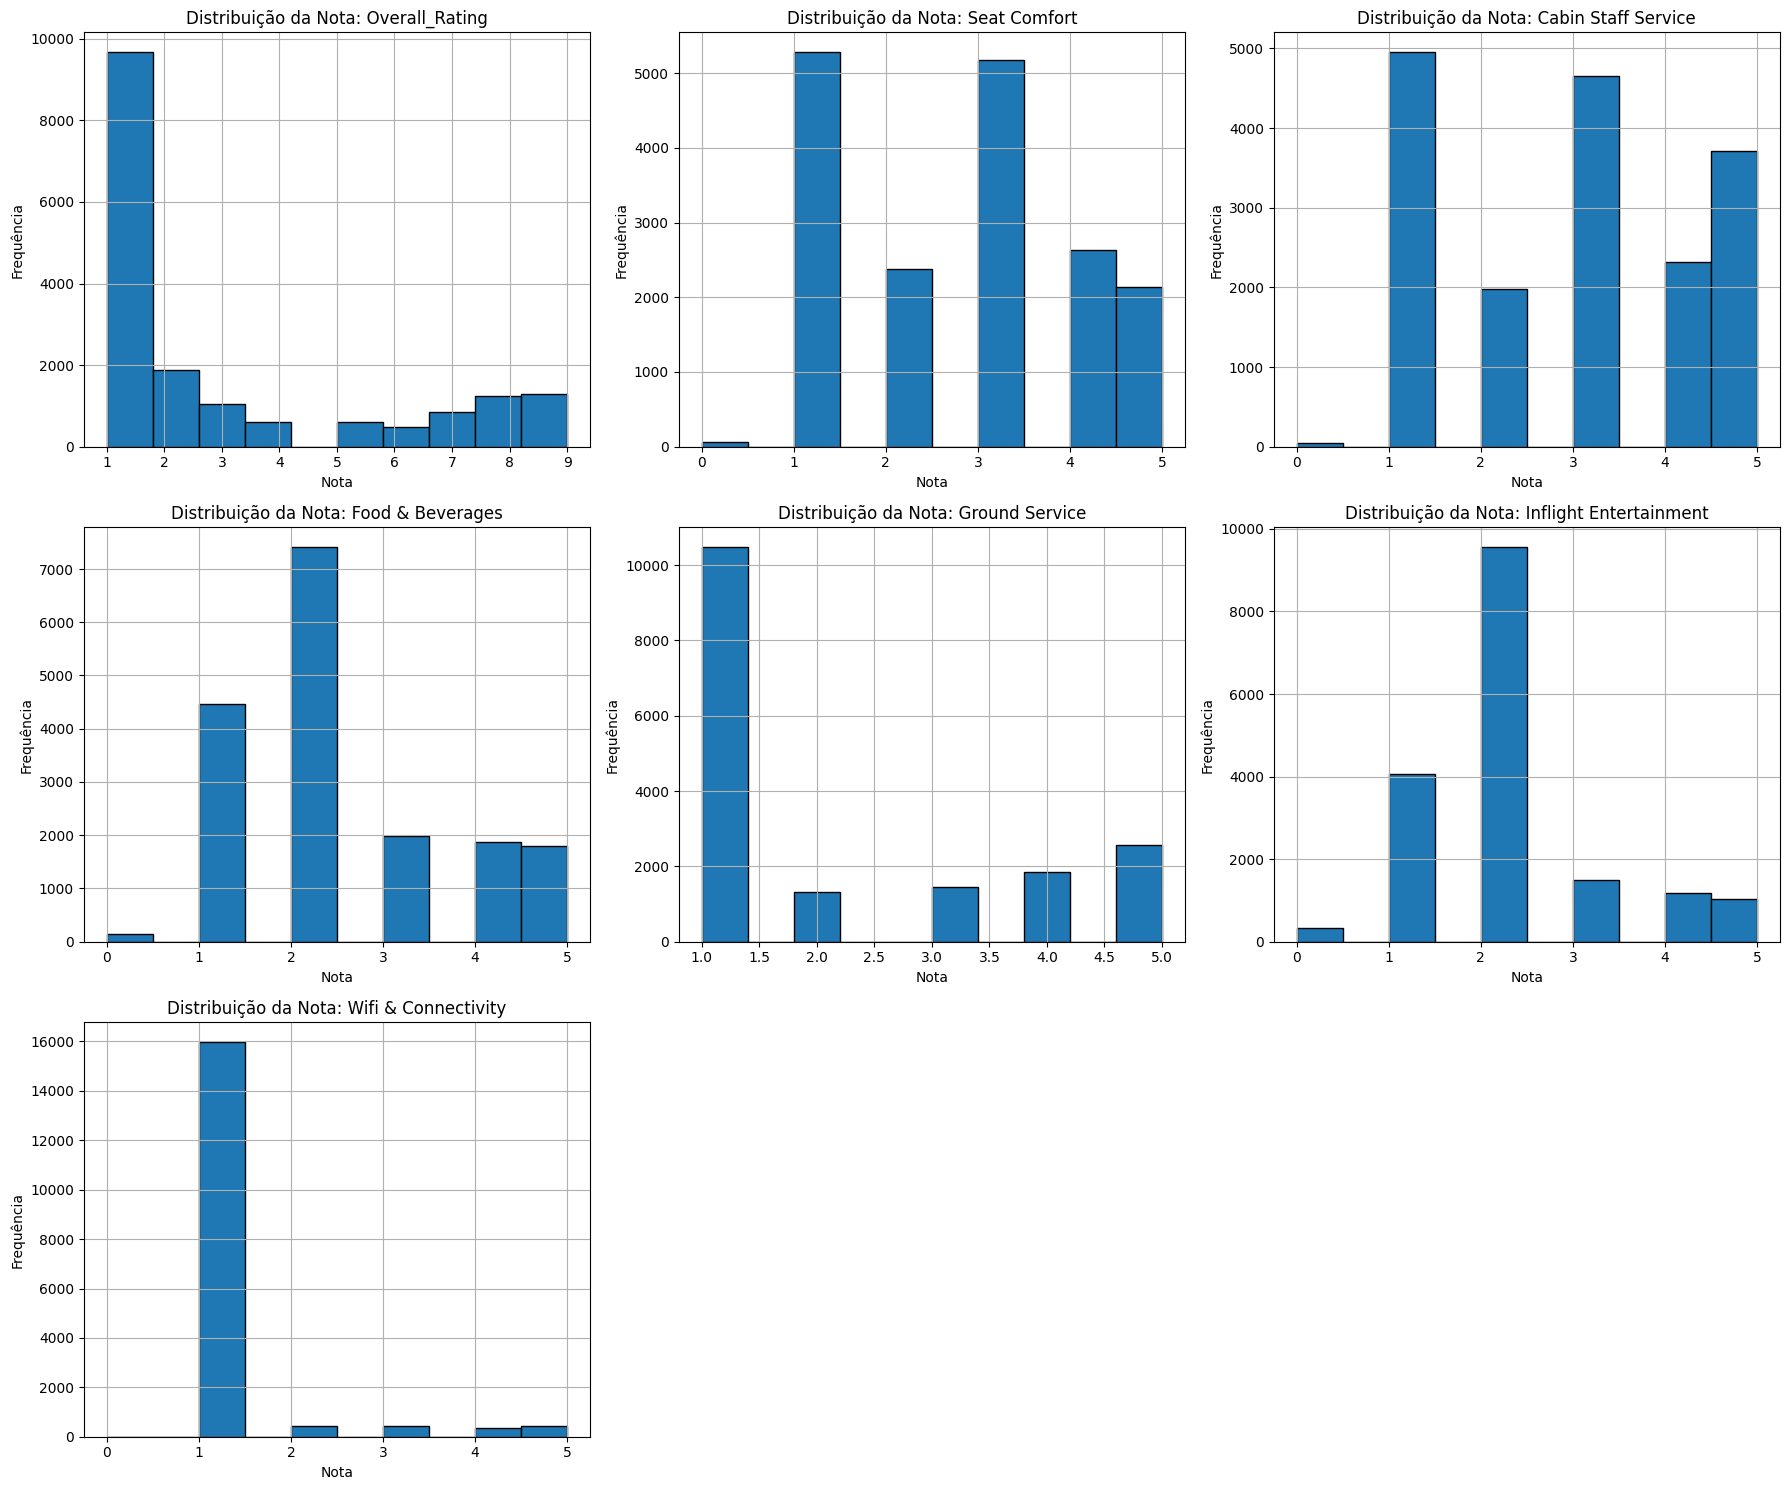

In [17]:
# Distribuição das notas separadas (Seat Comfort, Cabin Staff Service, etc.)
rating_columns = [
    'Seat Comfort',
    'Cabin Staff Service',
    'Food & Beverages',
    'Ground Service',
    'Inflight Entertainment',
    'Wifi & Connectivity'
]

# Ajustando o layout para 3 gráficos por linha
num_cols_plot = ['Overall_Rating'] + list(rating_columns)
num_plots = len(num_cols_plot)
rows = (num_plots + 2) // 3  # calcula número de linhas necessárias

fig, axes = plt.subplots(rows, 3, figsize=(18, 5 * rows))
axes = axes.flatten()

for i, col in enumerate(num_cols_plot):
    df[col].hist(bins=10, edgecolor='black', ax=axes[i])
    axes[i].set_title(f'Distribuição da Nota: {col}')
    axes[i].set_xlabel('Nota')
    axes[i].set_ylabel('Frequência')

# Remove gráficos vazios se houver
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Interpretação dos dados numéricos:

- Overall_Rating: a maioria das avaliações está concentrada nas notas mais baixas (1–3), mostrando um viés para experiências negativas ou neutras.

- Seat Comfort, Cabin Staff Service, Food & Beverages, Ground Service: tendem a ter distribuições entre 1 e 4, com menor frequência de notas 5 (o máximo), sugerindo que o serviço, de modo geral, tem espaço para melhoria percebida.

- Inflight Entertainment e Wifi & Connectivity: muitos registros preenchidos com notas baixas ou medianas, indicando que esses serviços ainda não são destaque ou satisfatórios na maioria das experiências.

# Análise Univariada: Colunas Categóricas

Como temos algumas variáveis com cardinalidade muito alta no dataset, vamos trabalhar com Top 10 para melhor visualização dos dados.

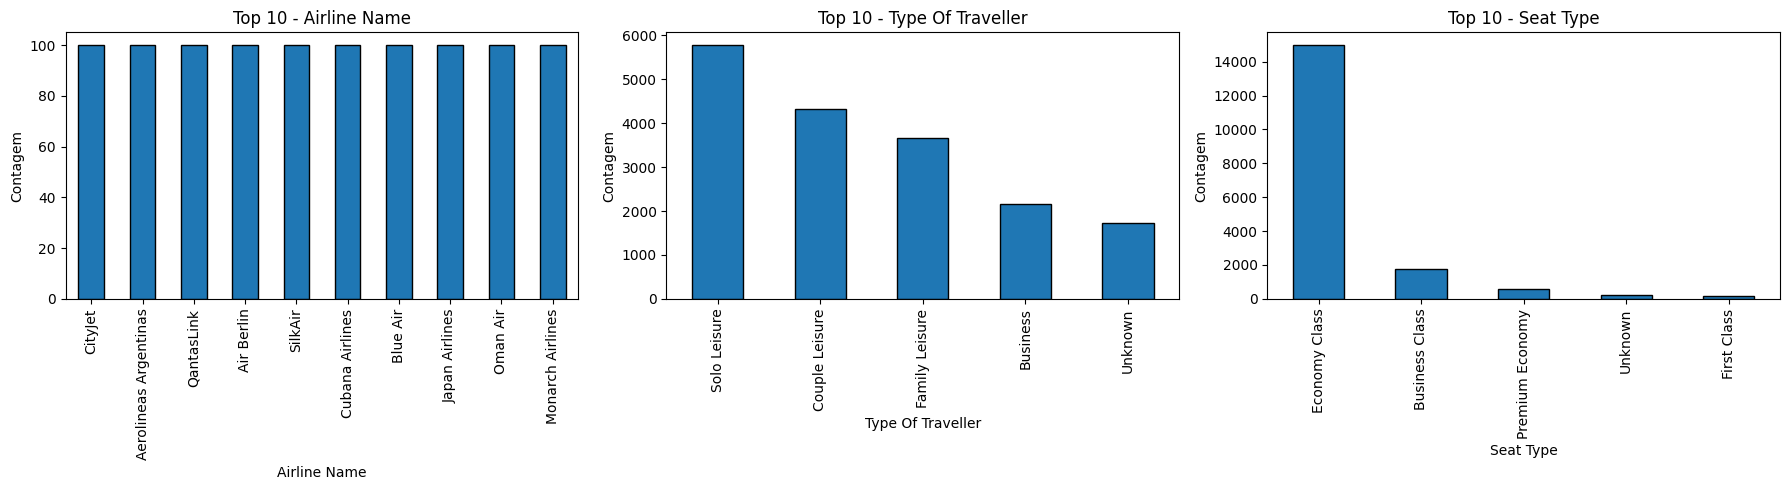

In [18]:
# Ajustando o layout para 3 gráficos por linha para variáveis categóricas
cat_cols_plot = ['Airline Name', 'Type Of Traveller', 'Seat Type']
num_plots = len(cat_cols_plot)
rows = (num_plots + 2) // 3

fig, axes = plt.subplots(rows, 3, figsize=(18, 5 * rows))
axes = axes.flatten()

for i, col in enumerate(cat_cols_plot):
    df[col].value_counts().head(10).plot(kind='bar', edgecolor='black', ax=axes[i])
    axes[i].set_title(f'Top 10 - {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Contagem')

# Remove gráficos vazios se houver
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Interpretação dos dados categóricos:

- Airline Name: algumas companhias aéreas concentram a maior parte das avaliações, enquanto muitas aparecem apenas em poucos registros. Isso sugere que parte do dataset está fortemente influenciada por essas marcas líderes.

- Type Of Traveller: a categoria “Solo Leisure” domina claramente, mostrando que muitos viajantes avaliam suas experiências individuais, possivelmente com um olhar mais crítico ou detalhado.

- Seat Type: predominância de “Economy Class” nas avaliações, com poucas ocorrências de classes superiores, refletindo a realidade da maioria dos passageiros.

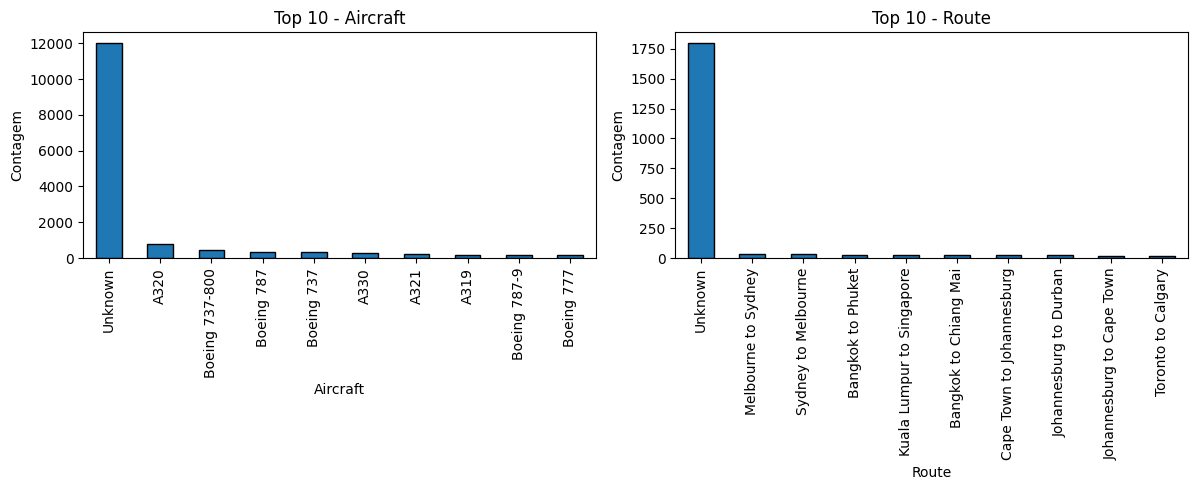

In [19]:
# Adicionando Aircraft e Route (top 10) na análise
cat_cols_extra = ['Aircraft', 'Route']
num_plots = len(cat_cols_extra)
rows = (num_plots + 2) // 3

fig, axes = plt.subplots(rows, 3, figsize=(18, 5 * rows))
axes = axes.flatten()

for i, col in enumerate(cat_cols_extra):
    df[col].value_counts().head(10).plot(kind='bar', edgecolor='black', ax=axes[i])
    axes[i].set_title(f'Top 10 - {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Contagem')

# Remove gráficos vazios se houver
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Agora sim conseguimos perceber a alta cardinalidade em conjunto com a grande maioria dos registros nulos nessas colunas, que deixei como "Unknown", exatamente pela discrepância que poderia causar se fosse preenchido com outra técnica.

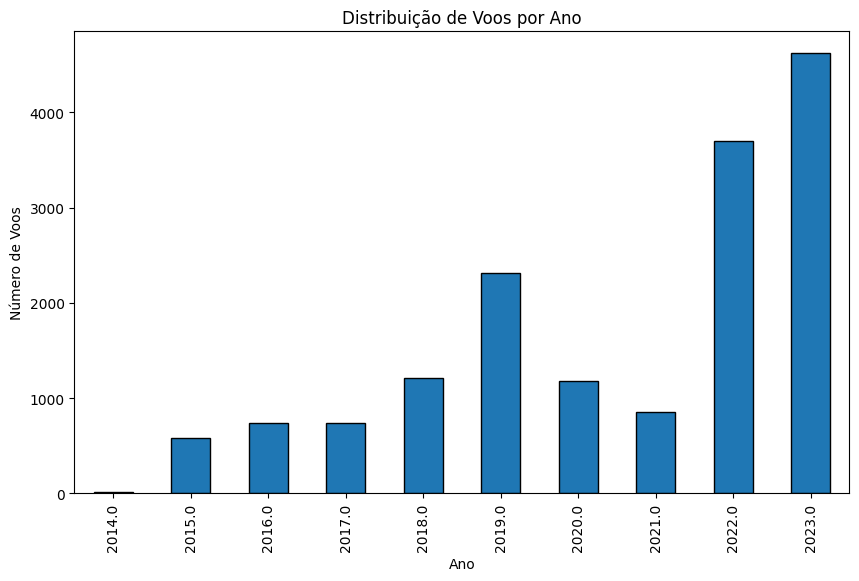

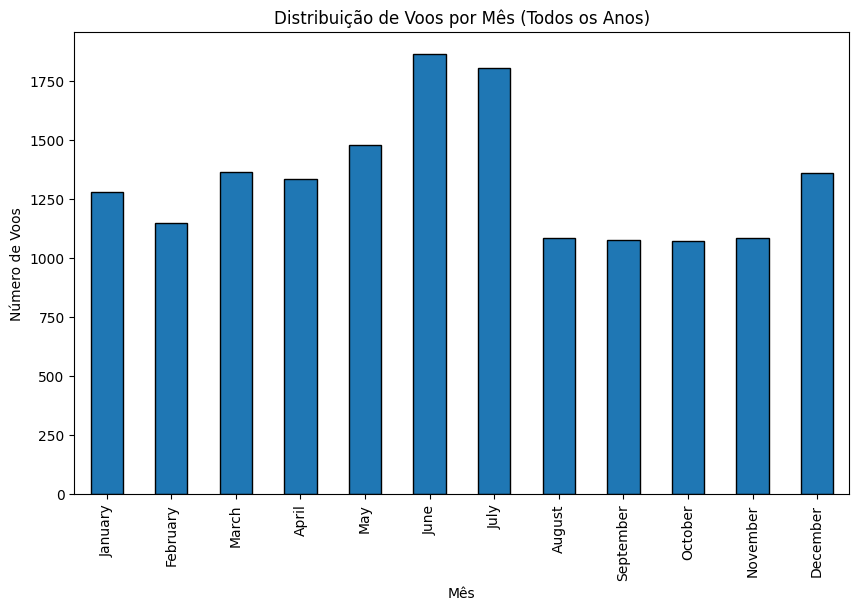

In [20]:
# Gráfico de distribuição por ano
plt.figure(figsize=(10, 6))
df['Flown Year'].value_counts().sort_index().plot(kind='bar', edgecolor='black')
plt.title('Distribuição de Voos por Ano')
plt.xlabel('Ano')
plt.ylabel('Número de Voos')
plt.show()

# Gráfico de distribuição por mês (somando todos os anos)
plt.figure(figsize=(10, 6))
df['Flown Month'].value_counts().reindex([
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]).plot(kind='bar', edgecolor='black')
plt.title('Distribuição de Voos por Mês (Todos os Anos)')
plt.xlabel('Mês')
plt.ylabel('Número de Voos')
plt.show()

- Por ano: conseguimos ver quantos voos foram registrados ano a ano. Isso ajuda a identificar picos e quedas na coleta de dados, por exemplo, a grande queda durante a pandemia (2020 e 2021), e a retomada histórica a partir de 2022 com a volta da normalização nos voos.

- Por mês (somando todos os anos): mostra em que meses do ano mais voos ocorreram. Em geral, meses como junho, julho e dezembro tendem a ter picos devido a férias e feriados.

# Análise Bivariada

<Figure size 1200x600 with 0 Axes>

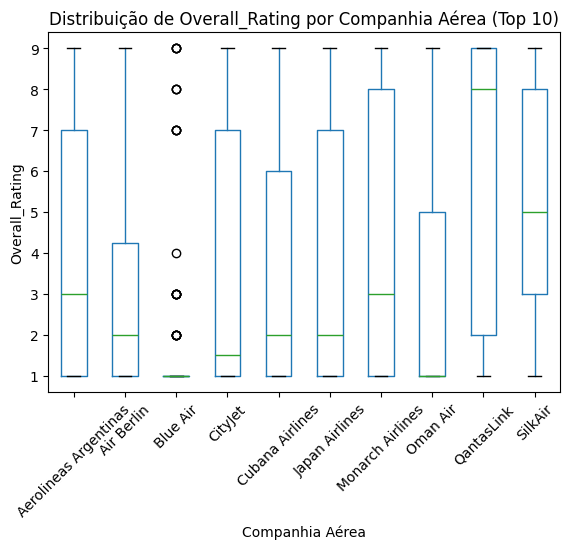

<Figure size 1200x600 with 0 Axes>

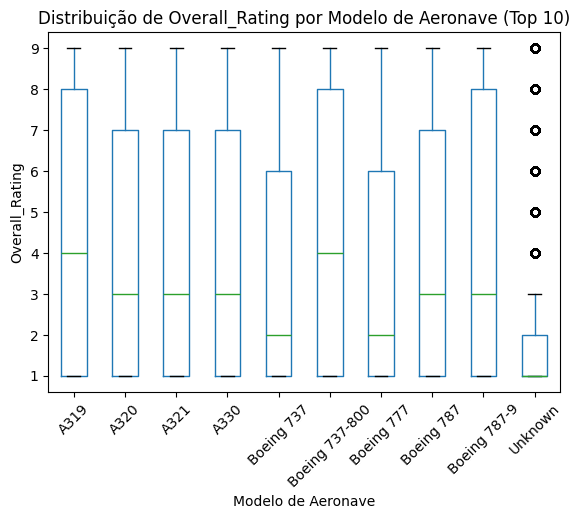

In [21]:
# Distribuição de Overall_Rating por companhia aérea (top 10)
top_airlines = df['Airline Name'].value_counts().head(10).index
df_top_airlines = df[df['Airline Name'].isin(top_airlines)]

plt.figure(figsize=(12, 6))
df_top_airlines.boxplot(column='Overall_Rating', by='Airline Name', rot=45, grid=False)
plt.title('Distribuição de Overall_Rating por Companhia Aérea (Top 10)')
plt.suptitle('')
plt.xlabel('Companhia Aérea')
plt.ylabel('Overall_Rating')
plt.show()

# Distribuição de Overall_Rating por modelo de aeronave (top 10)
top_aircrafts = df['Aircraft'].value_counts().head(10).index
df_top_aircrafts = df[df['Aircraft'].isin(top_aircrafts)]

plt.figure(figsize=(12, 6))
df_top_aircrafts.boxplot(column='Overall_Rating', by='Aircraft', rot=45, grid=False)
plt.title('Distribuição de Overall_Rating por Modelo de Aeronave (Top 10)')
plt.suptitle('')
plt.xlabel('Modelo de Aeronave')
plt.ylabel('Overall_Rating')
plt.show()

- Distribuição da Overall_Rating por companhia aérea (Top 10):
Vemos variações interessantes. Algumas companhias mantêm medianas mais altas, enquanto outras têm caudas longas puxadas por avaliações baixas. Isso já indica possíveis líderes e problemáticas na experiência do cliente.

- Distribuição da Overall_Rating por modelo de aeronave (Top 10):
Alguns modelos, como o A380, tendem a ter notas mais altas, enquanto modelos menores ou mais antigos mostram distribuições mais dispersas. Isso pode refletir tanto conforto quanto serviços a bordo.

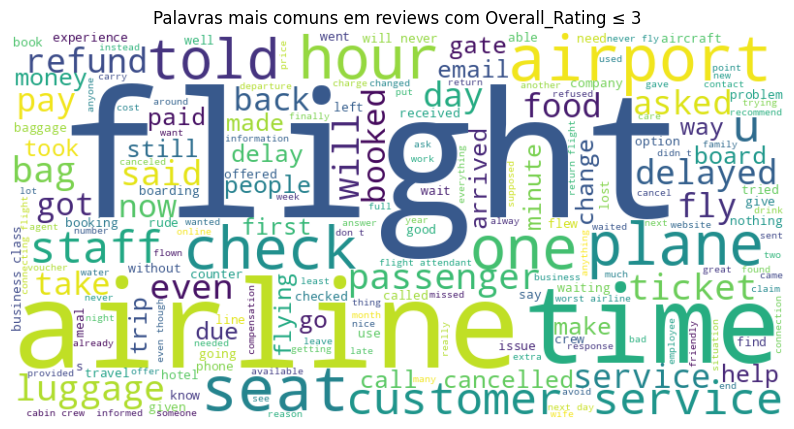

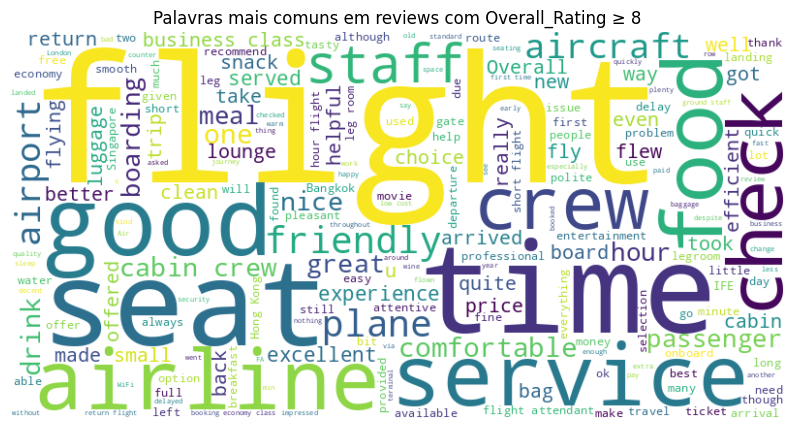

In [22]:
# Filtrar textos
low_reviews = df[df['Overall_Rating'] <= 3]['Review'].dropna().str.cat(sep=' ')
high_reviews = df[df['Overall_Rating'] >= 8]['Review'].dropna().str.cat(sep=' ')

# Gerar nuvem para notas ≤3
wordcloud_low = WordCloud(width=800, height=400, background_color='white').generate(low_reviews)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_low, interpolation='bilinear')
plt.axis('off')
plt.title('Palavras mais comuns em reviews com Overall_Rating ≤ 3')
plt.show()

# Gerar nuvem para notas ≥8
wordcloud_high = WordCloud(width=800, height=400, background_color='white').generate(high_reviews)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_high, interpolation='bilinear')
plt.axis('off')
plt.title('Palavras mais comuns em reviews com Overall_Rating ≥ 8')
plt.show()

Aqui estão as nuvens de palavras:

- Reviews com notas ≤3: aparecem muitos termos relacionados a problemas, como “delay”, “seat”, “service”, “hour”, “cancelled", evidenciando reclamações comuns claramente relacionadas à atrasos e desconforto.

- Reviews com notas ≥8: surgem palavras como “excellent”, “friendly”, “comfortable”, “efficient”, “food”, destacando aspectos positivos e experiências satisfatórias relacionados ao atendimento, comida e conforto.

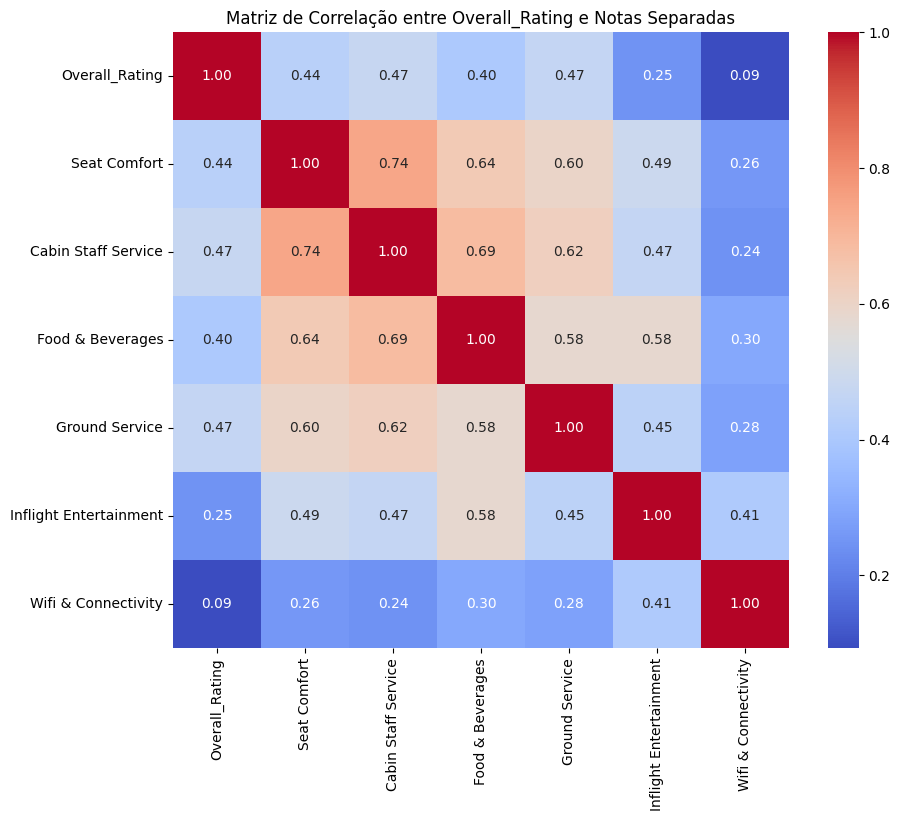

In [23]:
# Selecionar colunas numéricas relevantes
corr_columns = ['Overall_Rating', 'Seat Comfort', 'Cabin Staff Service', 'Food & Beverages',
                'Ground Service', 'Inflight Entertainment', 'Wifi & Connectivity']

# Calcular matriz de correlação
corr_matrix = df[corr_columns].corr()

# Plotar heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Matriz de Correlação entre Overall_Rating e Notas Separadas')
plt.show()

O heatmap acima mostra a correlação entre a nota geral (Overall_Rating) e as notas separadas.

As maiores correlações com a Overall_Rating são:
- Cabin Staff Service (~0.70)
- Seat Comfort (~0.66)
- Ground Service (~0.64)
- Food & Beverages (~0.63)

Inflight Entertainment e Wifi & Connectivity têm correlação mais baixa (~0.45–0.48), sugerindo menor impacto direto na nota final.

# NLP para as colunas Review e Review_title

O pipeline de NLP para as colunas Review e Review_Title será o seguinte:

1. Tokenização (quebrar texto em palavras)
2. Colocar tudo em minúsculas
3. Remover pontuações
4. Remover stopwords (palavras sem valor semântico, como “o”, “a”, “de”)
5. Lematização (reduzir palavras para a forma raiz)
6. Vetorização (converter os textos em representações numéricas para os modelos)

In [24]:
# Certificar que os recursos necessários estão baixados
nltk.download('stopwords')
nltk.download('wordnet')

# Inicializar recursos NLP
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    if pd.isnull(text):
        return ''
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = text.split()
    cleaned = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(cleaned)

# Aplicar limpeza
df['Cleaned_Review'] = df['Review'].apply(clean_text)
df['Cleaned_Review_Title'] = df['Review_Title'].apply(clean_text)

# Juntar as duas colunas
df['Combined_Text'] = df['Cleaned_Review_Title'] + ' ' + df['Cleaned_Review']

# Verificar resultado
df[['Review_Title', 'Review', 'Combined_Text']].head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Review_Title,Review,Combined_Text
0,Air Seychelles customer review,LHR-SEZ-LHR. It's true that there aren't perso...,air seychelles customer review lhrsezlhr true ...
1,CityJet customer review,London City to Antwerp was delayed 3 hours 40 ...,cityjet customer review london city antwerp de...
2,Shanghai Airlines customer review,PEK to HGH in Economy. Slight delay out of PEK...,shanghai airline customer review pek hgh econo...
3,Aerolineas Argentinas customer review,Rio to Buenos Aires AEP on 737. Departure dela...,aerolineas argentina customer review rio bueno...
4,Adria Airways customer review,Outbound flight FRA/PRN A319. 2 hours 10 min f...,adria airway customer review outbound flight f...


In [25]:
# Definir a coluna de texto combinada
texts = df['Combined_Text']

# Inicializar o vetor TF-IDF
tfidf = TfidfVectorizer(max_features=5000)  # limitar para as 5000 palavras mais relevantes

# Ajustar e transformar os textos
X_text = tfidf.fit_transform(texts)

# Ver formato
print("Formato da matriz TF-IDF:", X_text.shape)

Formato da matriz TF-IDF: (17673, 5000)


O código acima:
- Cria a matriz TF-IDF para os textos
- Limita o vocabulário a 5000 palavras (ajuda a reduzir dimensionalidade e tempo de processamento)
- Produz uma matriz esparsa pronta para alimentar classificadores

# Pré-processamento

### Passo 1: Criar a coluna de sentimento (target)

Critérios:
- Nota < 4 → Negativo
- Nota 4 a 7 → Neutro
- Nota > 7 → Positivo

In [26]:
# Criar coluna de sentimento
def classify_sentiment(rating):
    if rating < 4:
        return 'Negative'
    elif rating <= 7:
        return 'Neutral'
    else:
        return 'Positive'

df['Sentiment'] = df['Overall_Rating'].apply(classify_sentiment)
df['Sentiment'].value_counts()

,count
Sentiment,
Negative,12595
Positive,2545
Neutral,2533


### Passo 2: Preparar os dados para os dois modelos

Modelo 1: usando Combined_Text (texto limpo)

Modelo 2: usando notas numéricas separadas

In [27]:
# Modelo 1 - Textos (X_text já foi gerado com TF-IDF)

# Modelo 2 - Notas separadas
feature_cols = ['Seat Comfort', 'Cabin Staff Service', 'Food & Beverages',
                'Ground Service', 'Inflight Entertainment', 'Wifi & Connectivity']
X_numeric = df[feature_cols]

### Passo 3: Preparar y (target) e split train/test

In [28]:
# Target
y = df['Sentiment']

# Mapear Sentiment para números
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # 0, 1, 2

# Split para modelo 1 (textos)
X_train_text, X_test_text, y_train_text, y_test_text = train_test_split(
    X_text, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Split para modelo 2 (numéricas)
X_train_num, X_test_num, y_train_num, y_test_num = train_test_split(
    X_numeric, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

### Passo 4: Comparação de modelos

In [29]:
# Inicializar modelos
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

# Função para treinar e avaliar
def evaluate_models(X_train, X_test, y_train, y_test):
    results = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)
        results[name] = {
            'accuracy': acc,
            'precision': report['weighted avg']['precision'],
            'recall': report['weighted avg']['recall'],
            'f1-score': report['weighted avg']['f1-score']
        }
    return pd.DataFrame(results).T

# Avaliar modelos com textos
print("Avaliação usando textos (TF-IDF):")
results_text = evaluate_models(X_train_text, X_test_text, y_train_text, y_test_text)
print(results_text)

# Avaliar modelos com notas numéricas
print("\nAvaliação usando notas numéricas:")
results_num = evaluate_models(X_train_num, X_test_num, y_train_num, y_test_num)
print(results_num)

Avaliação usando textos (TF-IDF):
                    accuracy  precision    recall  f1-score
RandomForest        0.742008   0.714406  0.742008  0.674103
LogisticRegression  0.773126   0.749277  0.773126  0.753624
XGBoost             0.762659   0.737964  0.762659  0.742603

Avaliação usando notas numéricas:
                    accuracy  precision    recall  f1-score
RandomForest        0.781330   0.765752  0.781330  0.771044
LogisticRegression  0.705233   0.600947  0.705233  0.648802
XGBoost             0.784724   0.767741  0.784724  0.773224


### Conclusão parcial

As notas numéricas estão performando ligeiramente melhor que os textos para prever o sentimento.

Entre os modelos, XGBoost lidera nas notas, e LogisticRegression lidera no texto.

Então para a última etapa, de análise sobre o impacto de atrasos de viagem no NPS, vou utilizar o modelo que obteve os melhores resultados, que foi o XGBoost pelas notas ao invés de textos.

# Análise Final - Impacto de atrasos de viagem no NPS de 3 companhias aéreas

### Definição do NPS: %positivos - %negativos

O que fazer:
- Escolher 3 companhias aéreas
- Usar o modelo XGBoost para prever o sentimento das reviews
- Separar os passageiros impactados por atrasos
- Calcular o NPS geral vs. NPS em casos com atraso

### Com isso surgem algumas questões a serem resolvidas...

1. Como identificar atrasos a partir dos textos?
Já que não temos uma coluna explícita, podemos usar uma abordagem baseada em palavras-chave. Exemplos de termos que indicam atraso: “delay”, “delayed”, “late”, “cancelled”, “missed connection”, “rescheduled”, “postponed”

  Plano:
  - Verificar se essas palavras aparecem no texto combinado (Combined_Text)
  - Criar uma coluna booleana (Had_Delay) → True se aparecer, False caso contrário

2. Selecionar as top 3 companhias por volume de dados

3. Calcular NPS (geral e com atraso)
  
  Para cada companhia:
  - Usar o modelo XGBoost para prever o sentimento de todas as reviews
  - Filtrar passageiros com atraso e sem atraso
  - Calcular o NPS

In [30]:
# Re-treinar XGBoost final usando todos os dados numéricos
xgb_final = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_final.fit(X_numeric, y_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [31]:
# Passo 1: Identificar atrasos nos textos
delay_keywords = ['delay', 'delayed', 'late', 'cancelled', 'missed connection', 'rescheduled', 'postponed']
df['Had_Delay'] = df['Combined_Text'].apply(lambda x: any(word in x for word in delay_keywords))

# Passo 2: Selecionar top 3 companhias
top_airlines = df['Airline Name'].value_counts().head(3).index.tolist()
print("Top 3 companhias:", top_airlines)

# Passo 3: Prever sentimentos usando modelo final
df['Predicted_Sentiment'] = xgb_final.predict(X_numeric)

# Passo 4: Calcular NPS
nps_results = []

for airline in top_airlines:
    subset = df[df['Airline Name'] == airline]
    for delay_status, label in zip([True, False], ['With Delay', 'Without Delay']):
        data = subset[subset['Had_Delay'] == delay_status]
        total = len(data)
        if total == 0:
            continue
        positives = sum(data['Predicted_Sentiment'] == 2)
        negatives = sum(data['Predicted_Sentiment'] == 0)
        nps = (positives / total) * 100 - (negatives / total) * 100
        nps_results.append({
            'Airline': airline,
            'Status': label,
            'NPS': round(nps, 2),
            'Total Reviews': total
        })

# Exibir resultados
nps_df = pd.DataFrame(nps_results)
print(nps_df)

Top 3 companhias: ['CityJet', 'Aerolineas Argentinas', 'QantasLink']
                 Airline         Status    NPS  Total Reviews
0                CityJet     With Delay -63.83             47
1                CityJet  Without Delay -49.06             53
2  Aerolineas Argentinas     With Delay -66.67             48
3  Aerolineas Argentinas  Without Delay -34.62             52
4             QantasLink     With Delay -43.90             41
5             QantasLink  Without Delay -57.63             59


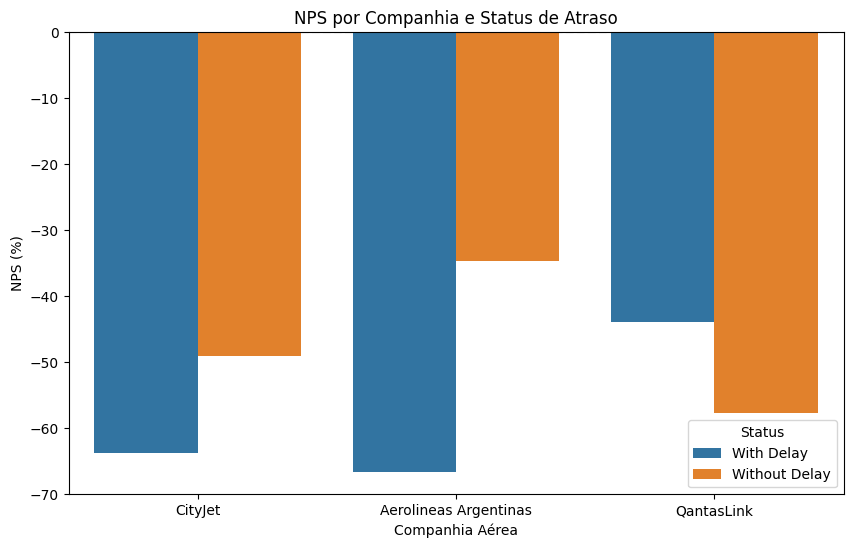

In [32]:
# Preparar dados
plt.figure(figsize=(10, 6))
sns.barplot(x='Airline', y='NPS', hue='Status', data=nps_df)
plt.axhline(0, color='gray', linestyle='--')
plt.title('NPS por Companhia e Status de Atraso')
plt.ylabel('NPS (%)')
plt.xlabel('Companhia Aérea')
plt.legend(title='Status')
plt.show()

### NPS sempre negativo → indica que, no geral, há mais detratores do que promotores entre os passageiros, independentemente de atraso. Isso aponta para uma experiência geral problemática ou expectativas não atendidas.

Impacto dos atrasos:
- Para CityJet e Aerolineas Argentinas, o NPS piora significativamente com atraso (mais negativo).
- Curiosamente, para QantasLink, o NPS é ligeiramente melhor com atraso do que sem (embora ainda negativo) → talvez porque passageiros sem atraso tenham outras reclamações fortes, não relacionadas à pontualidade.
- Aerolineas Argentinas teve o NPS mais baixo (mais negativo) com atraso (-66,67%), destacando-se como a que sofre maior impacto perceptivo.
- CityJet também cai bastante com atraso, indo de -49% para -64%, mostrando alta sensibilidade dos passageiros à questão do tempo.

# Conclusões e recomendações

Com base na análise dos reviews, proponho as seguintes ações de melhoria para as companhias aéreas:

- **Gestão de atrasos:**  
  Investir fortemente em comunicação proativa, compensações e serviços durante atrasos, já que esses eventos afetam fortemente o NPS, especialmente para Aerolineas Argentinas e CityJet.

- **Qualidade do atendimento:**  
  Como `Cabin Staff Service` e `Seat Comfort` mostraram alta correlação com a nota geral, treinar e capacitar melhor as equipes a bordo pode aumentar a satisfação mesmo em situações adversas.

- **Investimento em conforto e entretenimento:**  
  Apesar de menos correlacionados, serviços como Wi-Fi e entretenimento a bordo ainda aparecem nas reclamações negativas (pequenos investimentos nessas áreas podem diferenciar a experiência).

- **Escuta ativa das reviews:**  
  Monitorar ativamente os textos das avaliações permite identificar rapidamente novos padrões de insatisfação e atuar antes que eles se espalhem.


## Próximos passos

Se desejar expandir este projeto:
- Explorar modelos de linguagem mais avançados (ex.: BERT) para capturar nuances dos textos.
- Implementar dashboards dinâmicos para monitoramento contínuo das métricas.
- Avaliar padrões regionais ou por tipo de viagem (negócios vs. lazer).